## Unscented Kalman Filter  
-----

Найти положение робота в 1D пространстве, при этом используем данные с камеры, измеряя высоту отдаленных
ориентиров относительно горизонта.<br />



<img src="https://likerobotics.ru/images/task2.jpg" width="400"/>

### Исходные данные
Состояние
$$
\mathbf{x}=\left[\begin{array}{c}
p \\
\frac{d p}{d t}=\dot{p}
\end{array}\right]
$$
вход управления  $\quad \mathbf{u}=a=\frac{d^{2} p}{d t^{2}}$
<br />

Модель движения
$$
\begin{aligned}
\mathbf{x}_{k} &=\mathbf{f}\left(\mathbf{x}_{k-1}, \mathbf{u}_{k-1}, \mathbf{w}_{k-1}\right) \\
&=\left[\begin{array}{cc}
1 & \Delta t \\
0 & 1
\end{array}\right] \mathbf{x}_{k-1}+\left[\begin{array}{c}
0 \\
\Delta t
\end{array}\right] \mathbf{u}_{k-1}+\mathbf{w}_{k-1} \\
v_{k} & \sim \mathscr{N}(0,0.01) \quad \mathbf{w}_{k} \sim \mathscr{N}\left(\mathbf{0},(0.1) \mathbf{1}_{2 \times 2}\right)
\end{aligned}
$$

Модель измерения
$$
\begin{aligned}
y_{k} &=\phi_{k}=h\left(p_{k}, v_{k}\right) \\
&=\tan ^{-1}\left(\frac{S}{D-p_{k}}\right)+v_{k}
\end{aligned}
$$

Необходимо найти положение объекта в момент
времени 𝒌 + 𝟏, при ∆𝒕 = 𝟎. 𝟓 сек

$$
\begin{array}{cl}
\hat{\mathbf{x}}_{0} \sim \mathscr{N}\left(\left[\begin{array}{l}
0 \\
5
\end{array}\right],\right. & \left.\left[\begin{array}{cc}
0.01 & 0 \\
0 & 1
\end{array}\right]\right) \\
u_{0}=-2\left[\mathrm{~m} / \mathrm{s}^{2}\right] & y_{1}=\pi / 6[\mathrm{rad}] \\
S=20[\mathrm{~m}] & D=40[\mathrm{~m}]
\end{array}
$$

Подключаем необходимые библиотеки

In [ ]:
import numpy as np
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt
import math

Задаем исходные данные:


In [ ]:
x_0 = np.array([[0],[5]])
P_0 = np.array([[0.01 , 0],
                [0, 1]]) #ковариация в моментв ремени 0
Q_0 = np.array([[0.1 , 0],
                [0, 0.1]]) #ковариация модели движения в моментв ремени 0
R_0 = 0.01 #ковариация модели измерения в моментв ремени 0
u_0 = -2
y_1 = np.pi/6
S = 20
D = 40
dt = 0.5

### Начнем с предсказания
Для этого нам понадобится наша модель движения.

In [ ]:

def motion_iterate(dt, x_k, u_k):
    """
    example inputs:
    dt = 0.5
    x_k = 0
    u_k = -2
    """
    # motion model
    x_matrix = np.array([[1, dt], [0, 1]])
    u_matrix = np.array([[0], [dt]])
    x_k = x_matrix.dot(x_k) + u_matrix*u_k
    return x_k

In [ ]:
def measure_iterate(p_k, v_k, S, D):
    return np.arctan(S / (D - p_k)) + v_k




In [ ]:
2

2

Вспомнинаем, для N мерного распределения нам необходимо взять N+1 сигма точек.

In [ ]:
#разложение Холецкого для ковариационной матрицы
N = 2 # размерность распределения
ka = 3 - N # каппа, значнеие для нормального распределения
hol = cholesky(P_0)
print(hol)
#сигма точки нужно найти
sigma_list = []
sigma_list.append(x_0)
### START CODE HERE ###
for i in range(0, N):
    singma = x_0 + np.array(np.sqrt(N + ka) * hol[:,i]).reshape(2,1)
    sigma_list.append(singma)
for i in range(0, N):
    singma = x_0 - np.array(np.sqrt(N + ka) * hol[:,i]).reshape(2,1)
    sigma_list.append(singma)

### END CODE HERE ###
print(sigma_list)

[[0.1 0. ]
 [0.  1. ]]
[array([[0],
       [5]]), array([[0.173205],
       [5.      ]]), array([[0.      ],
       [6.732051]]), array([[-0.173205],
       [ 5.      ]]), array([[0.      ],
       [3.267949]])]


In [ ]:
# теперь пропускаем наши сигма точки через нелинейную функцию (модель движения)
# чтобы получить сигма  точки для момента времени k
sigma_predicted = np.zeros((len(sigma_list), 2, 1))
for i, sigma in enumerate(sigma_list):
    ### START CODE HERE ###
    print(sigma)
    news_sigma = motion_iterate(dt, sigma_list[i], -2)
    sigma_predicted[i] = news_sigma
    ### END CODE HERE ###

print('Predicted sigma points: ', sigma_predicted)

[[0]
 [5]]
[[0.173205]
 [5.      ]]
[[0.      ]
 [6.732051]]
[[-0.173205]
 [ 5.      ]]
[[0.      ]
 [3.267949]]
Predicted sigma points:  [[[2.5     ]
  [4.      ]]

 [[2.673205]
  [4.      ]]

 [[3.366025]
  [5.732051]]

 [[2.326795]
  [4.      ]]

 [[1.633975]
  [2.267949]]]


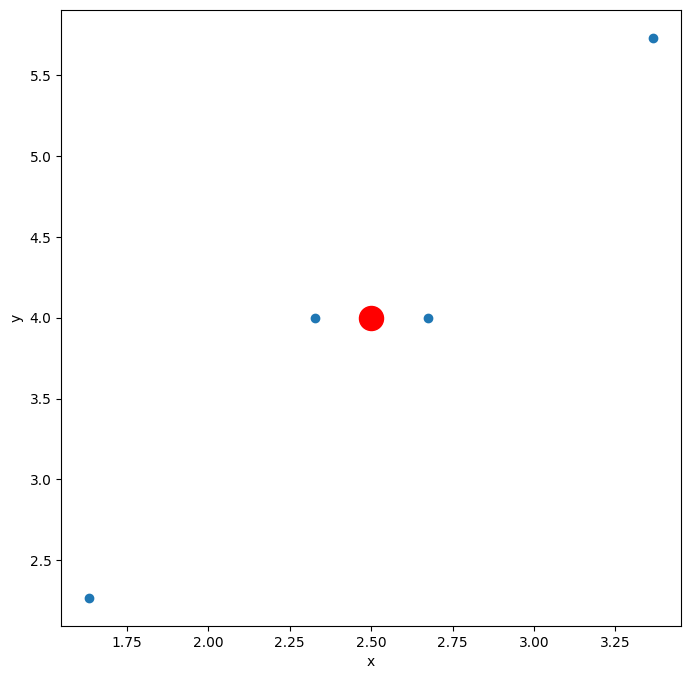

In [ ]:
plt.figure(figsize=(8, 8))
mean_x = sigma_predicted[:,0].mean(axis=0)
mean_y = sigma_predicted[:,1].mean(axis=0)
plt.scatter(sigma_predicted[:,0], sigma_predicted[:,1])
plt.scatter(mean_x, mean_y, color='red', s=300)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Раcчет парметров выходных данных(предсказанных): среднего и ковариации.

In [ ]:
#коэффициенты надо посчитать
a_list = []
a_list.append(ka/(N+ka))
a_list.append(0.5 * 1/(N+ka))
#инициализируем переменные для нового распределения
x_new = np.zeros((2, 1))
P_new = np.zeros((2, 2))
#среднее нового распределения
for i in range(2*N+1):
  if i == 0:
    x_new += a_list[0]*sigma_predicted[i]
    continue
  x_new += a_list[1]*sigma_predicted[i]

#ковариация нового распределения
for i in range(2*N+1):
  if i == 0:
    P_new += a_list[0]*(sigma_predicted[i] - x_new)@((sigma_predicted[i] - x_new).T)
    continue
  P_new += a_list[1]*(sigma_predicted[i] - x_new)@((sigma_predicted[i] - x_new).T)
P_new += Q_0

np.set_printoptions(precision=6, suppress=True)
print("The new mean:\n", x_new)
print("The new covariance:\n", P_new)

The new mean:
 [[2.5]
 [4. ]]
The new covariance:
 [[0.36 0.5 ]
 [0.5  1.1 ]]


### Теперь, зная наше предсказание, когда мы сделаем измерение, мы сможем сделать поправку
аналогичная процедура, только на этот раз с нелинейной моделью измерения
$$
\hat{\mathbf{y}}_{k}^{(i)}=\mathbf{h}_{k}\left(\check{\mathbf{x}}_{k}^{(i)}, \mathbf{0}\right) \quad i=0 \ldots 2 N
$$

In [ ]:
#разложение уже нашего P_new
hol = cholesky(P_new)
print(hol)

# аналогично находим сигма точки
cor_sigma_list = []
cor_sigma_list.append(x_new[0,0])
for i in range(0,N):
  singma = x_new + np.array(np.sqrt(N + ka) * hol[i,:]).reshape(2,1)
  cor_sigma_list.append(singma[0,0])
for i in range(0, N):
    singma = x_new - np.array(np.sqrt(N + ka) * hol[i,:]).reshape(2,1)
    cor_sigma_list.append(singma[0,0])
print(cor_sigma_list)

[[0.6      0.      ]
 [0.833333 0.636832]]
[np.float64(2.5), np.float64(3.539230484541326), np.float64(3.943375672974064), np.float64(1.460769515458674), np.float64(1.056624327025936)]


In [ ]:
# аналогично прогоняем через модель
sigma_mes_list = []

for i, sigma in enumerate(cor_sigma_list):
    ### START CODE HERE ###
  news_sigma = measure_iterate(sigma,0,20,40)
  sigma_mes_list.append(news_sigma)

    ### END CODE HERE ###

print(sigma_mes_list)

[np.float64(0.4899573262537283), np.float64(0.5017175820877777), np.float64(0.5064315663996093), np.float64(0.4786937816119785), np.float64(0.474441544612606)]


Теперь считаем среднюю и ковариацию

In [ ]:
#среднее нового распределения
y_new = np.array([0.0])
P_y_new = np.array([0.0])
for i in range(2*N+1):
  if i == 0:
    y_new += a_list[0]*sigma_mes_list[i]
    continue
  y_new += a_list[1]*sigma_mes_list[i]

#ковариация нового распределения
for i in range(2*N+1):
  if i == 0:
    P_y_new += a_list[0]*(sigma_mes_list[i] - y_new)@((sigma_mes_list[i] - y_new).T)
    continue
  P_y_new += a_list[1]*(sigma_mes_list[i] - y_new)@((sigma_mes_list[i] - y_new).T)
P_y_new += R_0
#..
print("The new mean = ", y_new)
print("The new covariance = ", P_y_new)

The new mean =  [0.4902]
The new covariance =  [0.010129]


Считаем  кросс ковариацию, усилитель калмана и получаем финальное значение оценки


In [ ]:
P_xy = np.array([[0.0],[0.0]])
for i in range(2*N+1):
  if i ==0:
    P_xy = a_list[0]*(sigma_predicted[i] - x_new)@((sigma_mes_list[i] - y_new).T)
    continue
  P_xy += a_list[1]*(sigma_predicted[i] - x_new)@((sigma_mes_list[i] - y_new).T)

P_xy = P_xy.reshape(2,1)
print(P_xy)

[[0.005282]
 [0.009235]]


In [ ]:
#усилитель
K = P_xy/P_y_new
print(K)

[[0.521448]
 [0.911667]]


### Полученные результаты после применения UKF

In [ ]:
# финальная оценка после корректировки
x_1 = x_new + K * (y_1 - y_new)
print(x_1)

[[2.517416]
 [4.030449]]
